In [202]:
%load_ext autoreload
%autoreload 2
from physics_data import generate_harmonic_data
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
from physics_data import RandomSHODataset
masses = torch.arange(0.1,10.1,0.1)
dset = RandomSHODataset(masses,10,500,10)
p,t = dset.time_series, dset.time

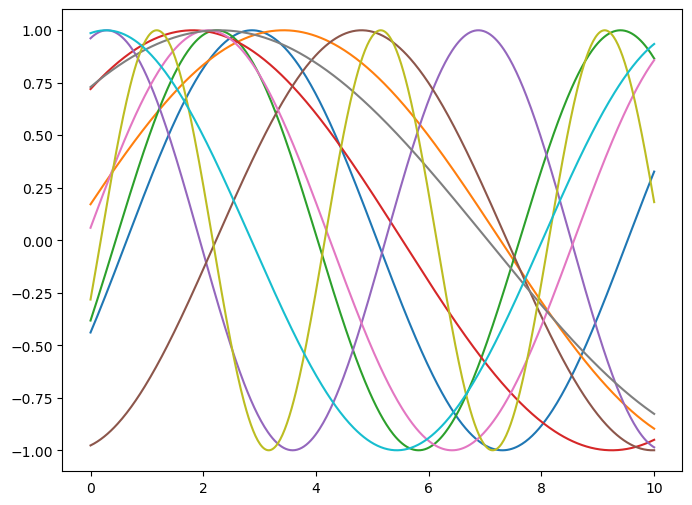

In [74]:
plt.figure(figsize=(8,6))
l = plt.plot(t.T,p.T)

# very small model

In [139]:
from model import GPT, GPTConfig
model_cfg = dict(
    block_size=1024, # maximum sequence length?
    input_dim=1, # default to 1d time-series data
    context_dim=3, # dimension of context vector (initial conditions)
    n_layer=6,
    n_head=4,
    n_embd=64, # embedding dimensions
    dropout=0.0,
    bias=False
)

# define model
gpt_config = GPTConfig(**model_cfg)
model = GPT(gpt_config)
model.load_state_dict(torch.load("trainings/random_SHO_05Dec24_1118/random_SHO_05Dec24_1118_best.pt",map_location='cpu'))

number of parameters: 0.30M


/tmp/ipykernel_2776170/1043745846.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trainings/random_SHO_05Dec24_1118/random_SHO_05Dec24

<All keys matched successfully>

In [200]:
from physics_data import RandomSHODataset
masses = torch.arange(0.1,10.1,0.1)
max_seq_length = 350
n_seq = 20
val_data = RandomSHODataset(masses,n_seq,max_seq_length,0.1)

x = val_data.time_series
ctx = val_data.context

tstart = 10
nstep = max_seq_length - tstart
xcurr = x[:,:tstart,:]
with torch.no_grad():
    for i in range(nstep):
        x_next = model(xcurr,ctx)
        xcurr = torch.cat([xcurr,x_next[:,-1:,:]],dim=1)

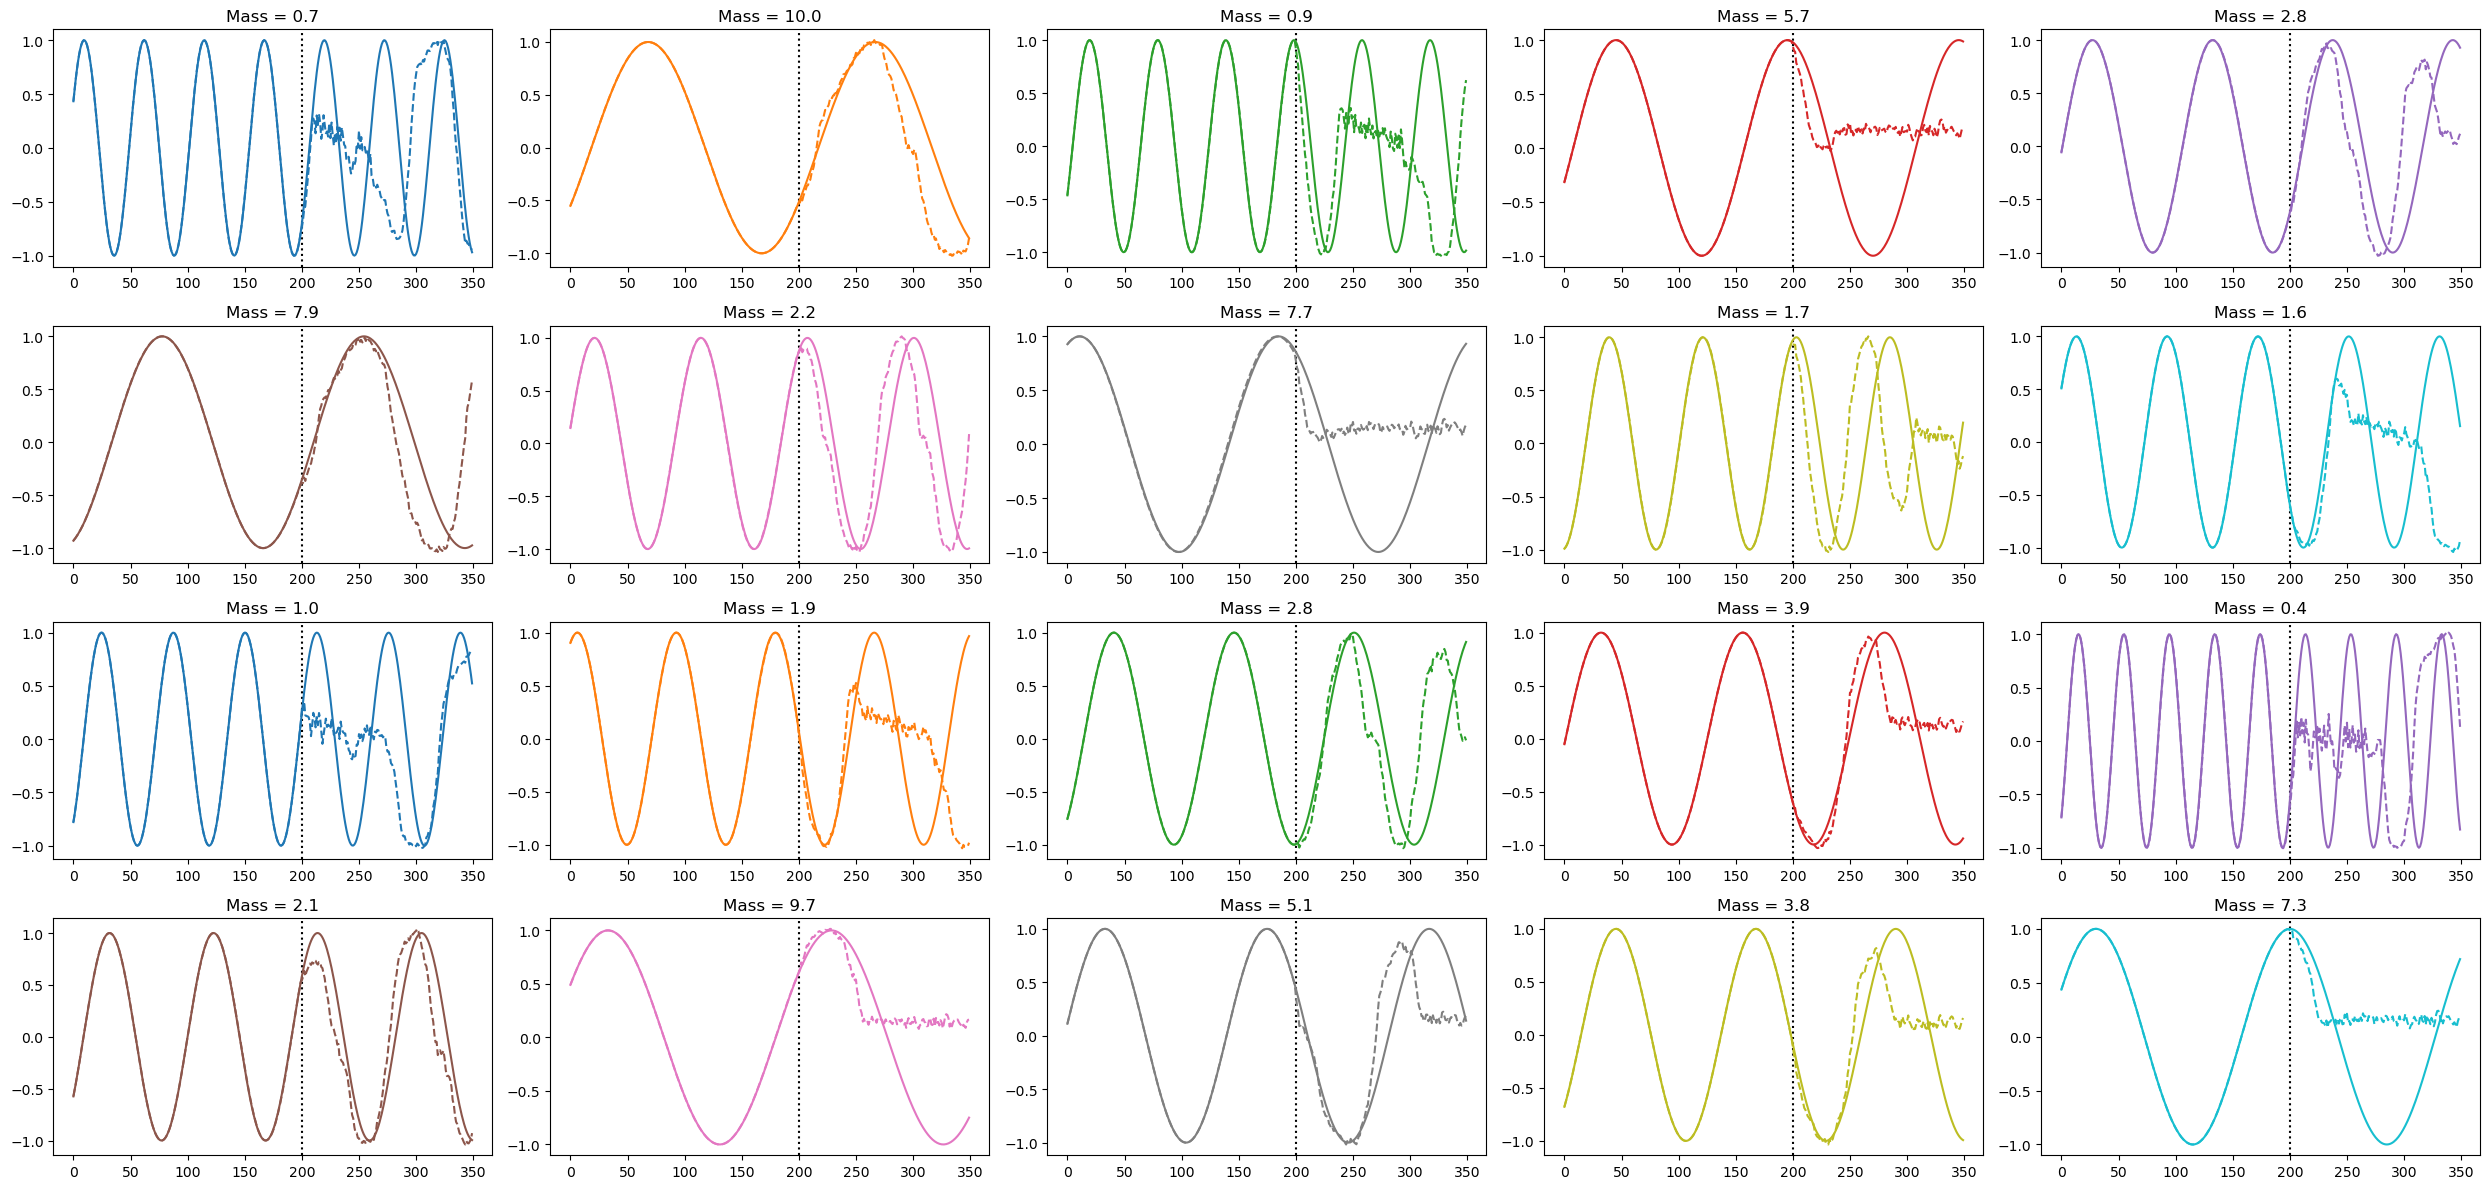

In [201]:
import math

xref = x.squeeze(-1)
xpred = xcurr.squeeze(-1)
tref = np.arange(xref.shape[-1])
tpred = np.arange(xpred.shape[-1])

masses = val_data.rand_masses
n_mass = len(masses)
n_col = 5
n_row = math.ceil(n_mass/n_col)

fig,axes = plt.subplots(n_row,n_col,figsize=(5*n_col,3*n_row))

for idx in range(xref.shape[0]):
    irow = idx//n_col
    icol = idx % n_col
    plt.sca(axes[irow,icol])
    plt.plot(tref,xref[idx:idx+1].T,color=f"C{idx}",zorder=1)
    plt.plot(tpred,xpred[idx:idx+1].T,linestyle='--',color=f"C{idx}",zorder=1)
    plt.title(f"Mass = {masses[idx]:.1f}")
    plt.axvline(200,color='k',linestyle=':',zorder=0)
plt.tight_layout()
plt.savefig("randMasses_timeSeries_smallTest.png")

In [158]:
from physics_data import SHODataset
masses = torch.arange(0.1,10.1,0.1)
max_seq_length = 350
n_seq = 20
val_data = SHODataset(masses,max_seq_length,0.1)

x,tgt,ctx,mask = val_data[:]

tstart = 10
nstep = max_seq_length - tstart
xcurr = x[:,:tstart,:]
with torch.no_grad():
    for i in range(nstep):
        x_next = model(xcurr,ctx)
        xcurr = torch.cat([xcurr,x_next[:,-1:,:]],dim=1)

In [175]:
x = val_data.time_series

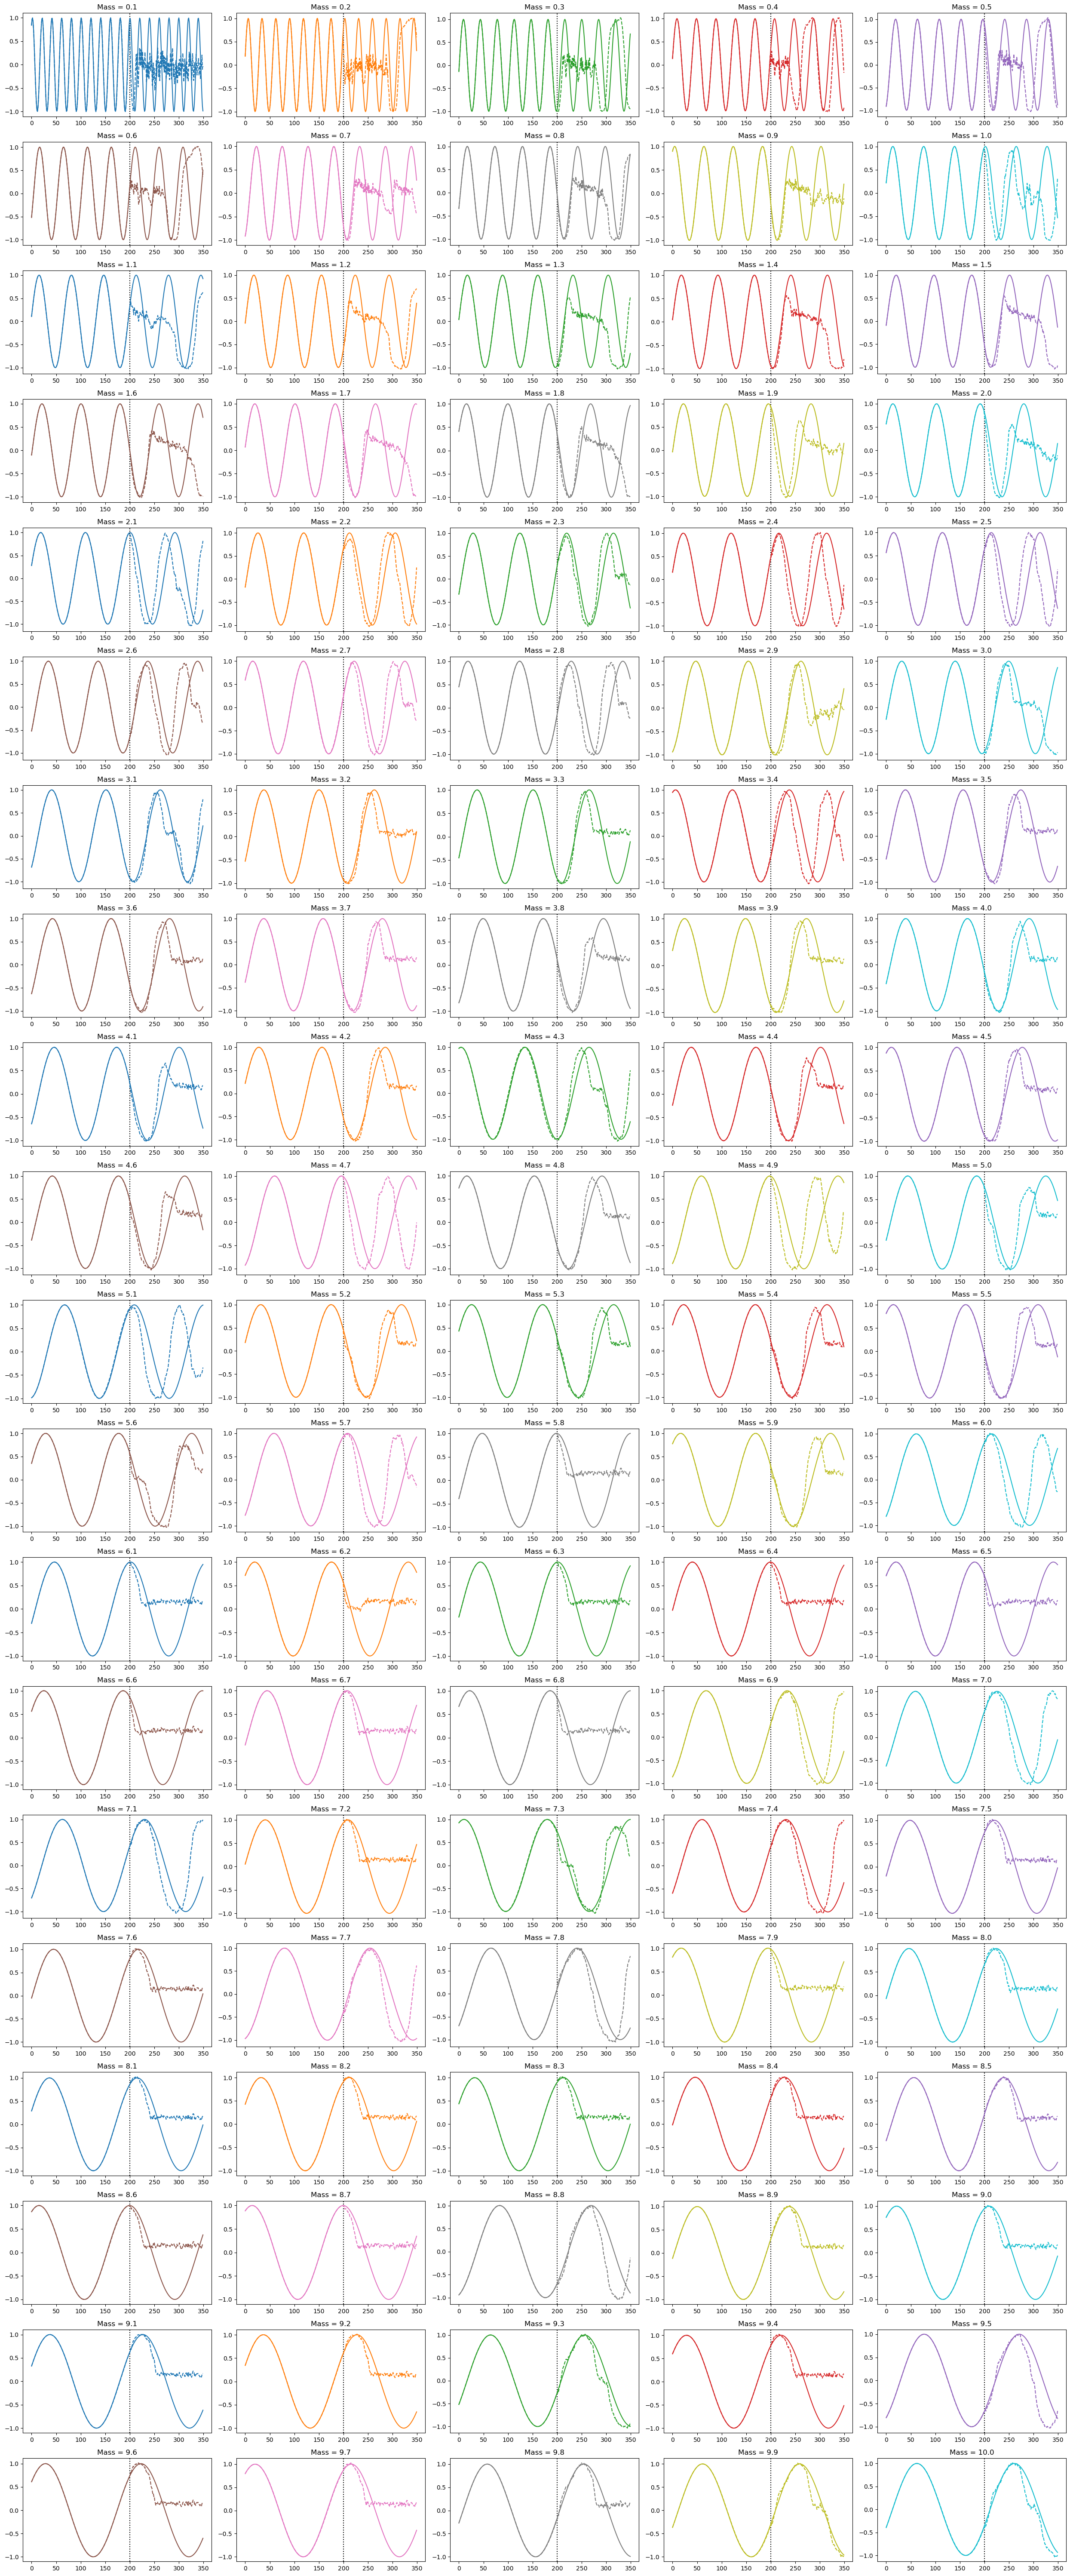

In [176]:
import math

xref = x.squeeze(-1)
xpred = xcurr.squeeze(-1)
tref = np.arange(xref.shape[-1])
tpred = np.arange(xpred.shape[-1])

masses = val_data.masses
n_mass = len(masses)
n_col = 5
n_row = math.ceil(n_mass/n_col)

fig,axes = plt.subplots(n_row,n_col,figsize=(5*n_col,3*n_row))

for idx in range(xref.shape[0]):
    irow = idx//n_col
    icol = idx % n_col
    plt.sca(axes[irow,icol])
    plt.plot(tref,xref[idx:idx+1].T,color=f"C{idx}",zorder=1)
    plt.plot(tpred,xpred[idx:idx+1].T,linestyle='--',color=f"C{idx}",zorder=1)
    plt.title(f"Mass = {masses[idx]:.1f}")
    plt.axvline(200,color='k',linestyle=':',zorder=0)
plt.tight_layout()
plt.savefig("allMasses_timeSeries_smallTest.png")

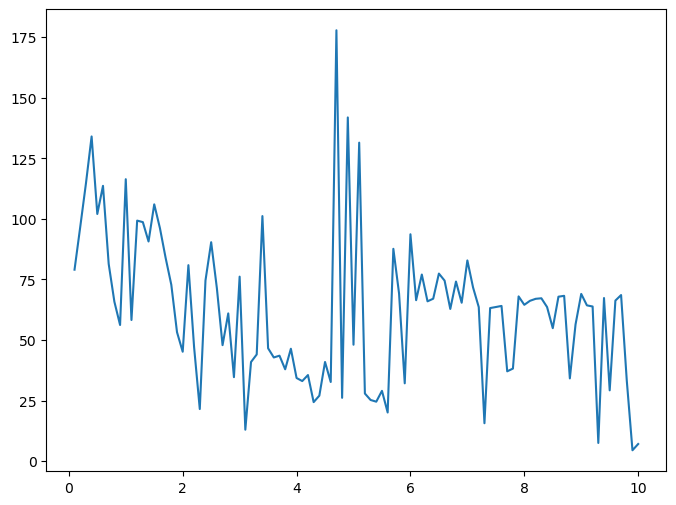

In [177]:
plt.figure(figsize=(8,6))
mses = []
for idx in range(xref.shape[0]):
    m = masses[idx]
    true = xref[idx,200:]
    pred = xpred[idx,200:]
    mse = ((true-pred)**2).sum()
    mses.append(mse)
plt.plot(masses,mses)

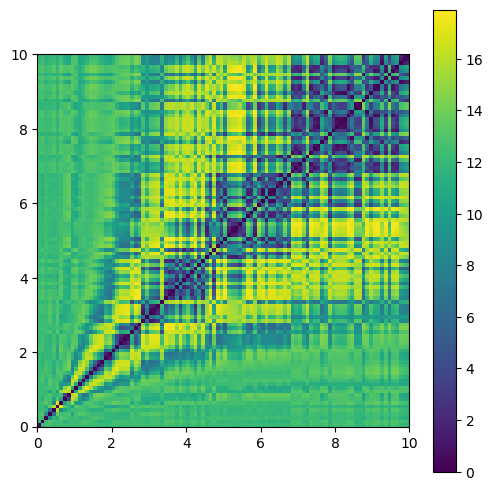

In [195]:
d = torch.cdist(xref[:,200:],xref[:,200:],p=2)
plt.figure(figsize=(6,6))
plt.imshow(d.T,extent=[0,10,0,10],origin='lower')
plt.colorbar()

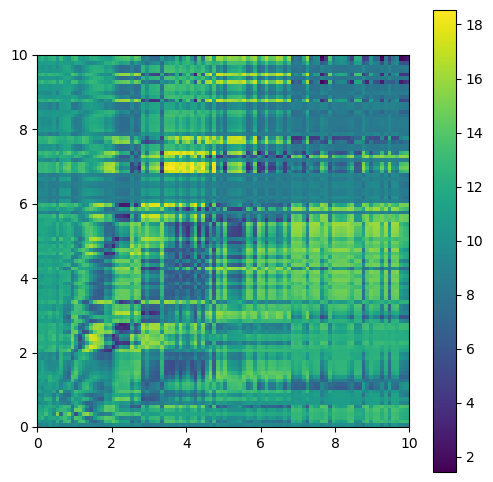

In [196]:
d = torch.cdist(xref[:,200:],xpred[:,200:],p=2)
plt.figure(figsize=(6,6))
plt.imshow(d.T,extent=[0,10,0,10],origin='lower')
plt.colorbar()

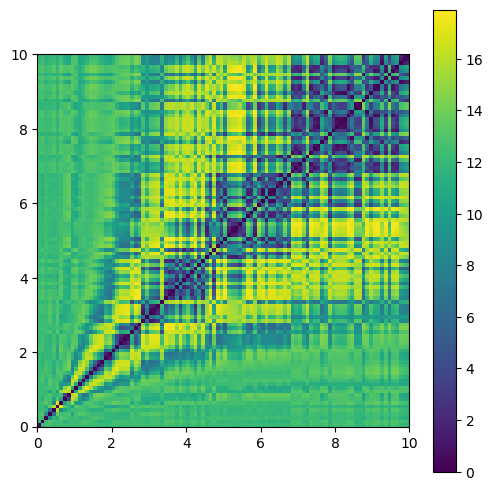

In [197]:
d = torch.cdist(xref[:,200:],xref[:,200:],p=2)
plt.figure(figsize=(6,6))
plt.imshow(d.T,extent=[0,10,0,10],origin='lower')
plt.colorbar()

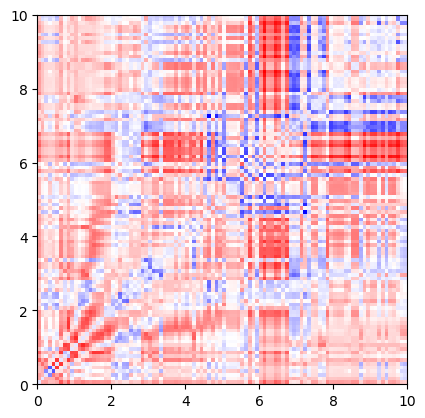

In [198]:
d1 = torch.cdist(xref[:,200:],xref[:,200:],p=2)
d2 = torch.cdist(xpred[:,200:],xpred[:,200:],p=2)
plt.imshow((d1-d2).T,extent=[0,10,0,10],origin='lower',cmap='bwr')

# slightly larger model & more epochs

In [210]:
from model import GPT, GPTConfig
src = "trainings/random_SHO_05Dec24_1414/"
with open(f"{src}/model_cfg.json","r") as fin:
    model_cfg = json.load(fin)
# define model
gpt_config = GPTConfig(**model_cfg)
model = GPT(gpt_config)
model.load_state_dict(torch.load(f"{src}/random_SHO_05Dec24_1414_best.pt",map_location='cpu'))

number of parameters: 0.49M


/tmp/ipykernel_2776170/873875065.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{src}/random_SHO_05Dec24_1414_best.pt",map_location='

<All keys matched successfully>

In [211]:
from physics_data import RandomSHODataset
masses = torch.arange(0.1,10.1,0.1)
max_seq_length = 350
n_seq = 20
val_data = RandomSHODataset(masses,n_seq,max_seq_length,0.1)

x = val_data.time_series
ctx = val_data.context

tstart = 10
nstep = max_seq_length - tstart
xcurr = x[:,:tstart,:]
with torch.no_grad():
    for i in range(nstep):
        x_next = model(xcurr,ctx)
        xcurr = torch.cat([xcurr,x_next[:,-1:,:]],dim=1)

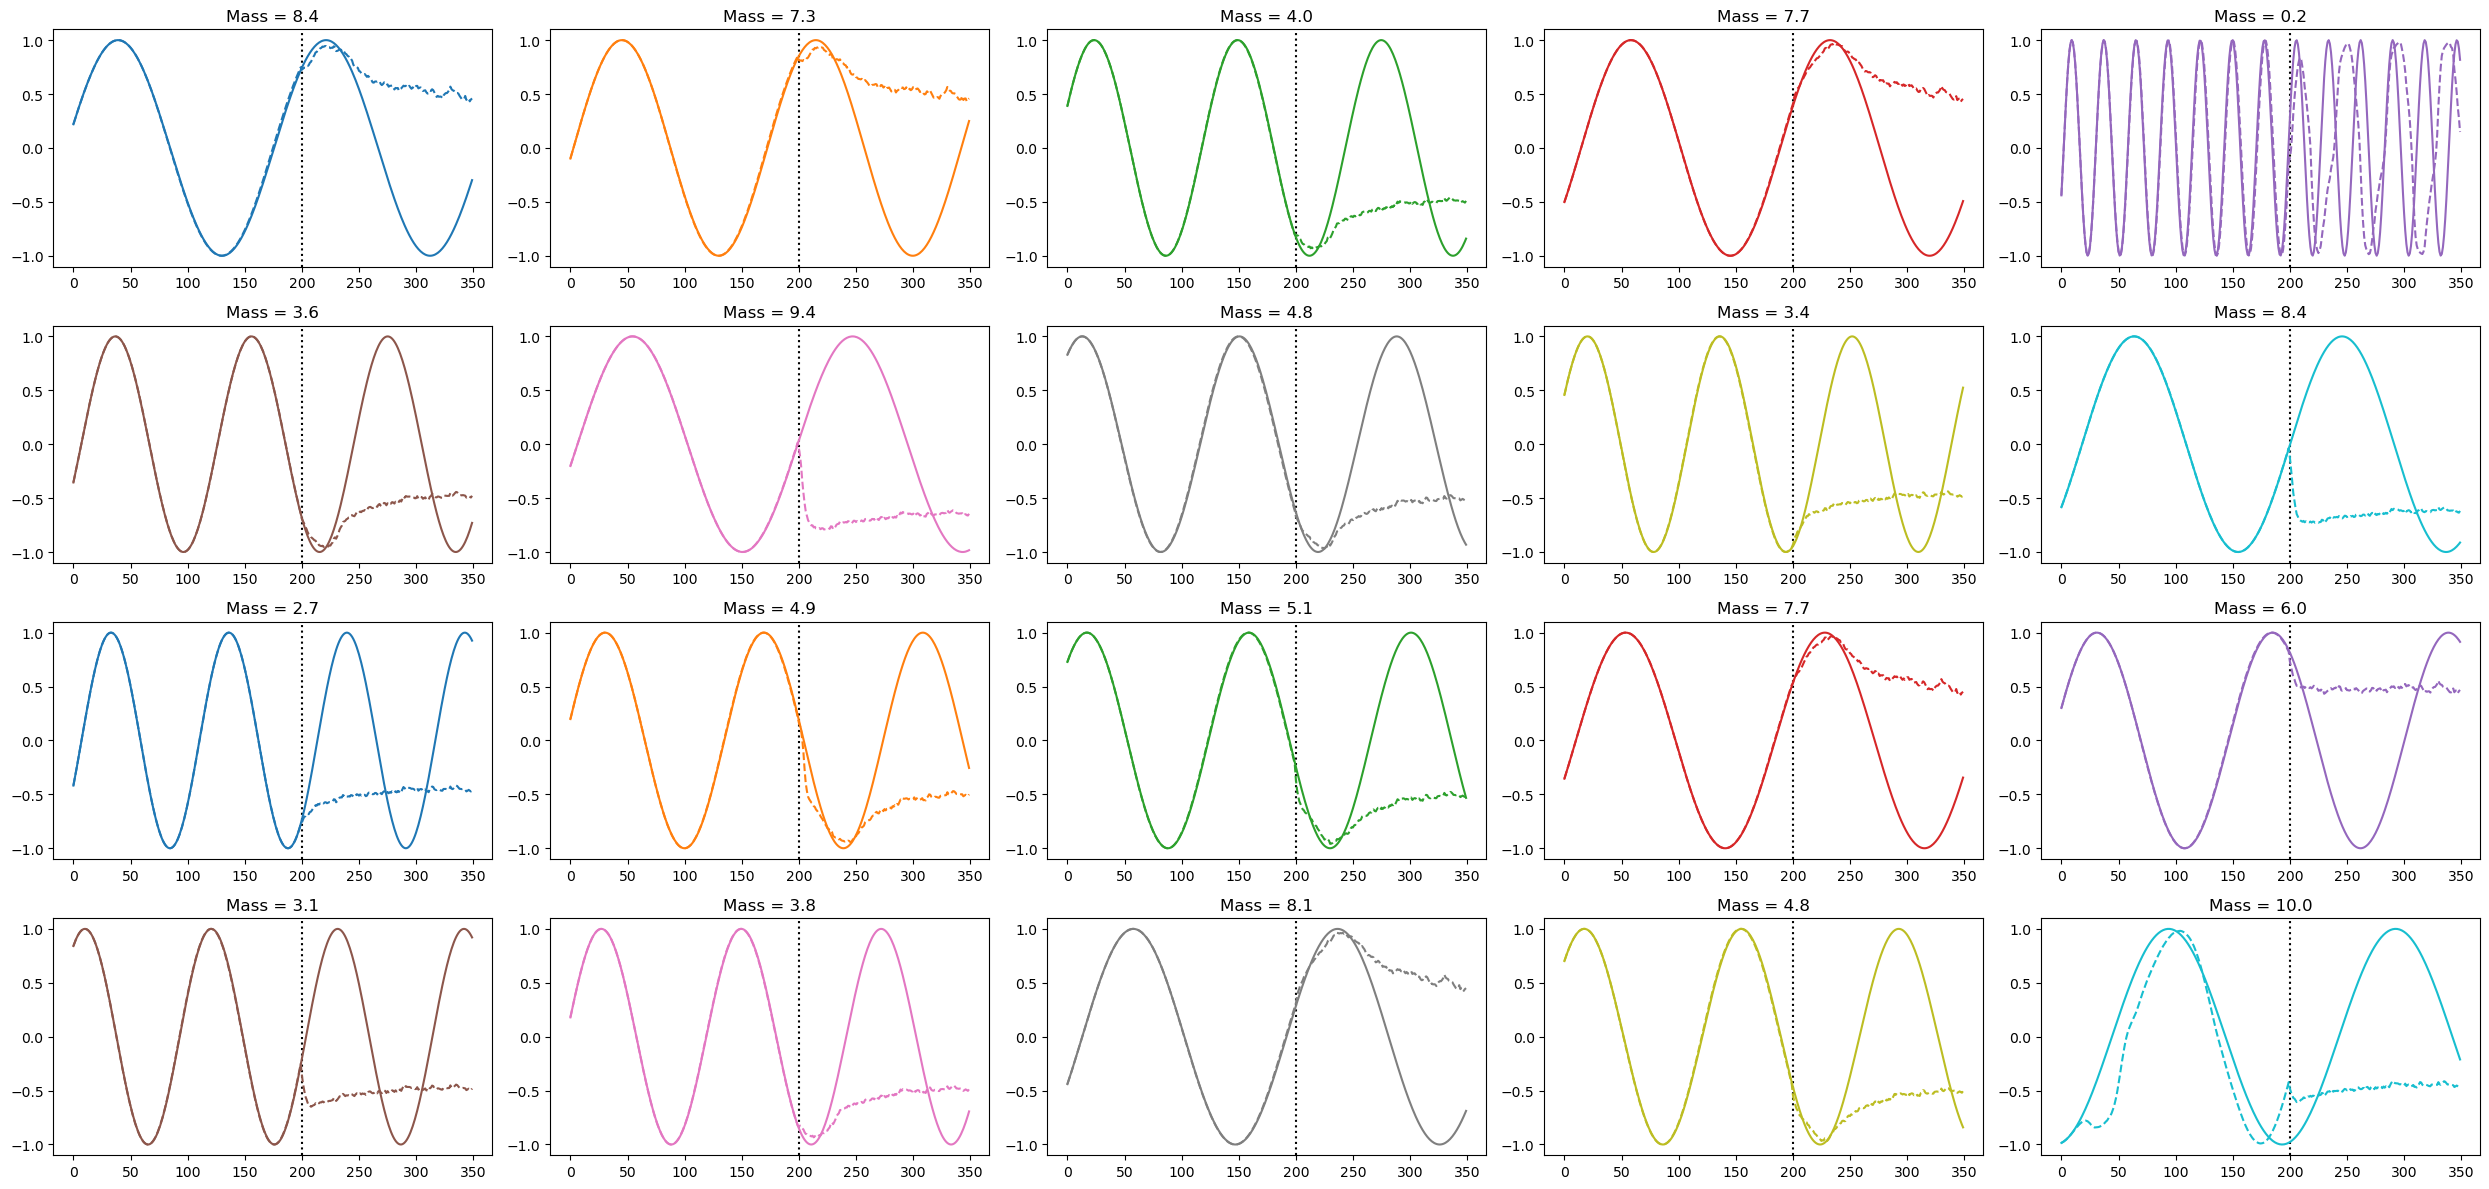

In [212]:
import math

xref = x.squeeze(-1)
xpred = xcurr.squeeze(-1)
tref = np.arange(xref.shape[-1])
tpred = np.arange(xpred.shape[-1])

masses = val_data.rand_masses
n_mass = len(masses)
n_col = 5
n_row = math.ceil(n_mass/n_col)

fig,axes = plt.subplots(n_row,n_col,figsize=(5*n_col,3*n_row))

for idx in range(xref.shape[0]):
    irow = idx//n_col
    icol = idx % n_col
    plt.sca(axes[irow,icol])
    plt.plot(tref,xref[idx:idx+1].T,color=f"C{idx}",zorder=1)
    plt.plot(tpred,xpred[idx:idx+1].T,linestyle='--',color=f"C{idx}",zorder=1)
    plt.title(f"Mass = {masses[idx]:.1f}")
    plt.axvline(200,color='k',linestyle=':',zorder=0)
plt.tight_layout()
plt.savefig("randMasses_timeSeries_biggerTest.png")

/tmp/ipykernel_2776170/3612326456.py:4: RuntimeWarning: divide by zero encountered in divide
  w = np.sqrt(k/m)


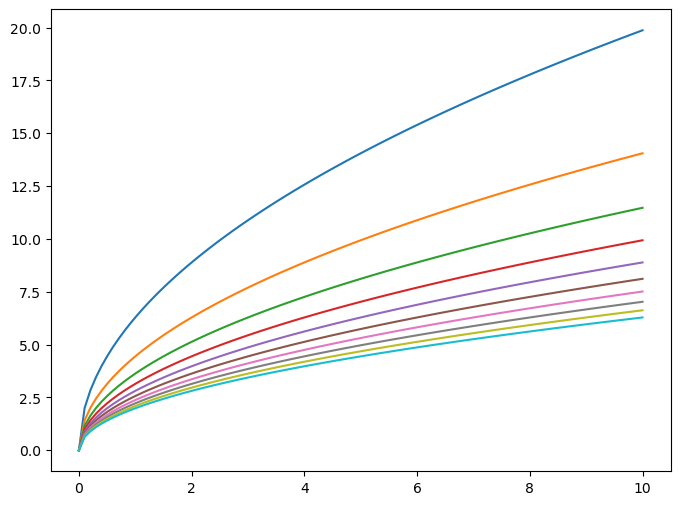

In [209]:
m = np.linspace(0,10,100)
plt.figure(figsize=(8,6))
for k in np.arange(1,11):
    w = np.sqrt(k/m)
    plt.plot(m,2*np.pi/w)

# small model (like the first) but alter training
sample masses uniformly on [0.1,4] and [5,10] rather than choosing from discrete set in steps of 0.1. maybe disincentivizes memorization?
also train on a larger dataset (1M) and use different learning rate: baseline of 5e-4 with min lr of 1e-5

In [215]:
type(masses) == torch.Tensor

True